#Traffic volume

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('/Users/polina/Desktop/bn_traffic/blocksnet/data/blocks.parquet')
blocks_gdf.head(2)

,geometry,site_area,capacity_convenience,capacity_cafe,capacity_mall,capacity_pharmacy,capacity_bank,capacity_fuel,capacity_pitch,capacity_playground,...,capacity_bus_stop,capacity_pier,capacity_animal_shelter,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse,capacity_machine_building_plant,population
id,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",804466.712114,208.0,0.0,2216.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,565.0
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",23173.129862,811.0,25.0,0.0,0.0,148.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0


In [2]:
# get number of services from capacity
capacity_cols = [c for c in blocks_gdf.columns if 'capacity' in c]

dfs = []
for cap in capacity_cols:
    temp = blocks_gdf[['geometry', cap]].copy()
    temp['count'] = temp[cap] / 100
    temp = temp[['count']]
    dfs.append(temp)
dfs[0].head()
blocks_gdf = blocks_gdf[['geometry','site_area','population']]

In [3]:
# add 'land_use' to blocks
blocks_lu = gpd.read_parquet('/Users/polina/Desktop/bn_traffic/blocksnet/data/blocks_lu')
blocks_gdf = blocks_gdf.merge(blocks_lu[['land_use']],left_on='id',right_on='id')
blocks_gdf.head()

,geometry,site_area,population,land_use
id,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",8.044667e+05,565.0,None
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",2.317313e+04,42.0,transport
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",3.630058e+05,19.0,recreation
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",1.964145e+05,600.0,residential
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",1.781752e+06,1967.0,recreation


In [4]:
# Get walk and drive graphs
import pickle
import momepy
with open("/Users/polina/Desktop/bn_traffic/blocksnet/data/graph.pkl", "rb") as f:
    G_drive = pickle.load(f)
n,e = momepy.nx_to_gdf(G_drive)

with open("/Users/polina/Desktop/bn_traffic/blocksnet/data/walk_graph.pkl", "rb") as f:
    G_walk = pickle.load(f)

In [5]:
import pandas as pd

accessibility_matrix = pd.read_pickle('/Users/polina/Desktop/bn_traffic/blocksnet/data/accessibility_matrix.pickle')
accessibility_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,16310,16311,16312,16313,16314,16315,16316,16317,16318,16319
0,0.000000,18.718750,9.234375,17.21875,30.296875,27.390625,30.671875,23.281250,78.6875,81.2500,...,76.5625,102.5625,97.5000,132.250,130.8750,142.125,247.625,228.625,247.625,124.6250
1,17.859375,0.000000,19.015625,7.65625,20.281250,25.250000,25.234375,15.765625,76.8750,79.4375,...,74.6875,100.7500,95.6875,130.500,129.0000,140.250,245.875,226.875,245.875,112.5000
2,9.234375,20.796875,0.000000,20.21875,27.968750,25.062500,28.343750,20.953125,71.8750,74.4375,...,69.7500,95.8125,90.6875,125.500,124.0625,135.375,240.875,221.875,240.875,124.6250
3,15.937500,7.449219,18.421875,0.00000,21.109375,24.984375,27.781250,16.593750,76.3125,78.8125,...,74.1250,100.1875,95.0625,129.875,128.5000,139.750,245.250,226.250,245.250,113.3750
4,31.906250,19.765625,31.734375,21.28125,0.000000,21.781250,23.125000,15.429688,89.5625,92.1250,...,87.4375,113.5000,108.3750,143.125,141.7500,153.000,258.500,239.500,258.500,108.3125


In [6]:
# Get diversity and density attributes
from blocksnet.analysis.centrality import service_centrality

centrality_df = service_centrality(accessibility_matrix, blocks_gdf, dfs, diversity_weight=10)
centrality_df.rename(columns={'shannon_diversity':'diversity'},inplace=True)
blocks = blocks_gdf.merge(centrality_df[['diversity', 'density']],left_on='id',right_index=True)
blocks.head()

,geometry,site_area,population,land_use,diversity,density
id,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",8.044667e+05,565.0,None,0.836565,0.000030
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",2.317313e+04,42.0,transport,0.867563,0.000388
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",3.630058e+05,19.0,recreation,0.693147,0.000014
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",1.964145e+05,600.0,residential,0.749937,0.000423
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",1.781752e+06,1967.0,recreation,0.775580,0.000035


In [7]:
# Extract only Vasilievskiy Island blocks
import osmnx as ox

local_crs = 32636
polygon = ox.geocode_to_gdf(f'R1114252', by_osmid=True).to_crs(local_crs)
blocks = gpd.overlay(blocks,polygon).copy()
blocks = blocks[['land_use', 'population', 'density', 'diversity','geometry','site_area']]

In [9]:
from blocksnet.analysis.network.traffic_volume import get_OD_mx, get_road_congestion

OD_mx = get_OD_mx(blocks, n, G_walk , G_drive, local_crs)
new_graph = get_road_congestion(OD_mx, G_drive)

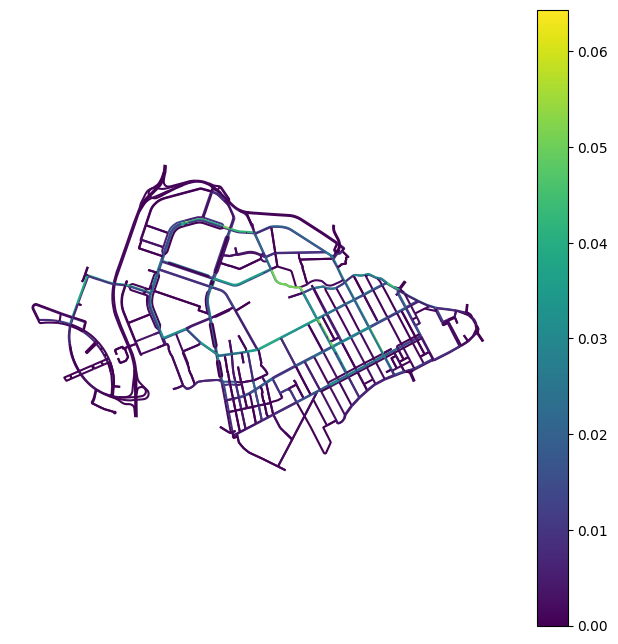

In [10]:
momepy.nx_to_gdf(new_graph)[1].plot('congestion', legend=True, figsize=(8, 8)).set_axis_off()